<a href="https://colab.research.google.com/github/agvaravin/DataAnalitic/blob/main/vkr_ad801_varavin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Квалификационная работа**
|||
|--:|:--|
|**поток** |"Аналитик данных: с нуля до разработки прикладных решений для бизнеса"|
|**группа** |801|
|**тема** |"Исследование ценовой политики розничной компании по выбранной номенклатуре товаров"|
|**автор** |Варавин А.Г.|

Нажми Ctrl + ] чтобы увидеть разделы проекта.

# Постановка задачи

Предлагается собрать информацию с действующего сайта розничных продаж в одной из категории товаров и провести анализ ценовой политики компании на предмет наличия ценовых сегментов. В случае их обнаружения проверить гипотезы о принадлежности различных вендоров к тем или иным ценовым сегментам, а также подтвердить предположение, что в ядре ценовых сегментов находятся наиболее популярные товары. Популярность товара будет определяться по его рейтингу и количеству вопросов, заданных аудитории сайта.

В качестве источника данных будет использован сайт сети магазинов DNS. В качестве группы товаров будут рассмотрены компьютерные видеокарты.

#**Скрейпинг сайта**

Поскольку сайт компании DNS является динамическим, для его скрейпинга будем применять бибилиотеку `Selenium`.

Вначале произведем установку бибилиотеки в среде Google Colaboratory.

In [ ]:
!pip install selenium
# !apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 995 kB 5.2 MB/s 
     |████████████████████████████████| 384 kB 37.8 MB/s 
     |████████████████████████████████| 140 kB 65.9 MB/s 
     |████████████████████████████████| 58 kB 5.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to 

Далее осуществим импорт необходмых для работы библиотек и подготовим две процедуры - `init_driver()` и `paginator()`. Первая осущетсвляет запуск драйвера браузера Chrome с параметрами, необходимыми для стабильной работы в среде Colab. Вторая позволят перебрать все страницы выбранной группы товаров, находя на странице элемент `next_class`, извлекая из соответствующего элемента ссылку и переходя по ней.

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import pandas as pd

def init_driver():
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver',options=chrome_options)
    driver.implicitly_wait(120)
    driver.wait = WebDriverWait(driver, 20)
    return driver

def paginator(wd, path):
    next_class = '.pagination-widget__page-link.pagination-widget__page-link_next'
    try:    
        wd.get(path)
        yield wd
        while True:
            next_href = wd.find_element(By.CSS_SELECTOR, next_class)\
                .get_attribute('href')
            wd.get(next_href)
            yield wd
    except:
        pass  

Теперь напишем процедуру скрейпинга, собирающую данные о следующих параметрах:

|Параметр|Описание|
|--:|:--|
|**Price**|Стоиимость единицы товара|
|**Rating**|Покупательский рейтинг товара|
|**Elect**|Количество проголосовавших за товар покупателей|
|**Vendor Model**|Описание товара, содержащее его производителя и модель|

In [ ]:
def dns_scraper(wd, scrapdata):
    elems = wd.find_elements(By.XPATH,'//div[@data-id="product"]')
    for e in elems:
        e.wait = WebDriverWait(e, 20)
        price = e.wait.until(EC.presence_of_element_located(
            (By.CSS_SELECTOR,'.product-buy__price')))
        model = e.wait.until(EC.presence_of_element_located(
            (By.CSS_SELECTOR,'.catalog-product__name')))
        rating = e.wait.until(EC.presence_of_element_located(
            (By.CSS_SELECTOR,'.catalog-product__rating')))
        scrapdata.append([price.text, model.text, rating.text,
                          rating.get_attribute('data-rating')])

Запустим код скрейпера на выбранной странице категорий товаров. Данные соберем в python-список для последующей обработки.

In [ ]:
lnk = 'https://www.dns-shop.ru/catalog/17a89aab16404e77/videokarty/'
scrapdata = []

wd = init_driver()
for wdd in paginator(wd, lnk):
    dns_scraper(wdd, scrapdata)
wd.close()

Преобразуем полученые данные в датафрейм. Сохраним результат для последующего использования.

In [ ]:
df_read = pd.DataFrame(scrapdata,
                  columns = ['Price', 'Vendor Model', 'Elect', 'Rating'])
df_read.to_csv('scrapdata.csv', index=False)

#Скрейпинг сайта. Выводы
Собраны следующие данные:

|Параметр|Описание|
|--:|:--|
|**Price**|Стоиимость единицы товара|
|**Rating**|Покупательский рейтинг товара|
|**Elect**|Количество проголосовавших за товар покупателей|
|**Vendor Model**|Описание товара, содержащее его производителя и модель|

- Результаты сохранены в файл `scrapdata.csv`

In [ ]:
df_read

,Price,Vendor Model,Elect,Rating
0,3 799 ₽,Видеокарта PowerColor AMD Radeon R7 240 [AXR7 ...,99,4
1,4 099 ₽,Видеокарта KFA2 GeForce GT 710 PASSIVE [71GGF4...,50,4
2,4 099 ₽,Видеокарта Palit GeForce GT 710 Silent LP [NEA...,187,4.5
3,4 699 ₽,Видеокарта KFA2 GeForce GT 730 [70NPF4HX003K] ...,40,4.5
4,4 699 ₽,Видеокарта Palit GeForce GT 730 Silent LP [NEA...,46,4.5
...,...,...,...,...
277,139 999 ₽,Видеокарта GIGABYTE AORUS GeForce RTX 3080 Ti ...,нет отзывов,0
278,155 999 ₽,Видеокарта PNY Quadro RTX A4000 [VCNRTXA4000-P...,2,5
279,201 999 ₽,"Видеокарта PNY Tesla T4 [TCST4M-PB] [PCI-E, 16...",2,2
280,269 999 ₽,Видеокарта PNY Quadro RTX A5000 [VCNRTXA5000-P...,2,3


#**Предобработка**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Необходимые функции предобработки:

In [ ]:
# --Оценка пропусков
def pred_na_fit(df):
    A = df.isna()
    V = A.iloc[:, 0]
    for name, B in A.iteritems():
            V = V | B
    percent_na = V.value_counts()[True]/V.value_counts().sum()
    return V, percent_na
# --Удаление пропусков
def pred_na_clear(df, V):
    return df.loc[~V]

Проанализируем полученный датасет по следующему плану:
1. Единый формат заголовков
2. Приведение типов
3. Пропуски
4. Дубли
5. Семантика параметров, взаимосвязи
6. Единообразное написание категориальных параметров

In [ ]:
df = pd.read_csv('scrapdata.csv')
df.head()

,Price,Vendor Model,Elect,Rating
0,3 399 ₽,Видеокарта PowerColor AMD Radeon R7 240 [AXR7 ...,98,4.0
1,3 999 ₽,Видеокарта KFA2 GeForce GT 730 [70NPF4HX003K] ...,40,4.5
2,4 099 ₽,Видеокарта KFA2 GeForce GT 710 PASSIVE [71GGF4...,49,4.0
3,4 099 ₽,Видеокарта Palit GeForce GT 710 Silent LP [NEA...,187,4.5
4,12 999 ₽,Видеокарта GIGABYTE GeForce GTX 1630 OC Low Pr...,4,3.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         268 non-null    object 
 1   Vendor Model  273 non-null    object 
 2   Elect         273 non-null    object 
 3   Rating        273 non-null    float64
dtypes: float64(1), object(3)
memory usage: 8.7+ KB


In [ ]:
'всего дублей: {}'.format(
  df.duplicated().sum())

'всего дублей: 0'

**Вывод по ходу исследования**

1. Заголовки на английском языке содержат пробелы. Приведем их к строчным буквам и заменить пробелы на подчеркивания.
2. Поля `Price` и `Elect` требуют приведения к числовой форме.
3. Некоторые стобцы могут содержать пропуски (датасет меняется после очередного сеанса скрейпинга). Примем за допустимые 2% потерь от пропусков и при меньшем их количестве удалим сответствующие строки.
4. Дублей не выявлено.
5. Параметры `Price`, `Rating` и `Elect` являются интервальными. Остальные - категориальными.
6. Предлагается выделить вендора из названий модели для последующего анализа в качестве категорияльной переменной.

In [ ]:
# меняем заголовки
new_columns = df.columns.str.lower().str.strip().str.replace(' ','_')
df.columns = new_columns
# приводим столбцы к числовой форме
df['price']=pd.to_numeric(df['price'].replace(r'[^0-9]', '',regex=True))
df['elect']=pd.to_numeric(df['elect'].replace(r'[^0-9]', '',regex=True))
# выделим вендора и характеристики карты в отдельные столбцы
df[['garb','vendor','model']] = df['vendor_model'].str.split(' ',2,expand=True)
df.drop(columns=['garb','vendor_model'], inplace=True)
# приведем названия вендоров к написанию заглавными буквами
df.vendor = df.vendor.str.upper()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   268 non-null    float64
 1   elect   250 non-null    float64
 2   rating  273 non-null    float64
 3   vendor  273 non-null    object 
 4   model   273 non-null    object 
dtypes: float64(3), object(2)
memory usage: 10.8+ KB


После приведения типов часть значений в полях `elect` и `price` получились Nan. Не будем восстанавливать эти значения, а отнесем к пропускам.

In [ ]:
# оценка количества пропусков
V, per_na = pred_na_fit(df)
print('Процент потерь от пропусков {:.2%}.'.format(per_na))

Процент потерь от пропусков 10.26%.


Несмотря на значительный процент пропусков, предлагается удалить их, поскольку отсутствие оценок и стоимости делает кластеризацию таких товаров бессмысленной.

In [ ]:
# удаление пропусков
if per_na < 0.2:
    df_pred = pred_na_clear(df, V)
    print('Датасет очищен от пропусков.')
else:
    df_pred = df
    print('Датасет остался без изменений.')

Датасет очищен от пропусков.


#Предобработка. Выводы

- Датасет удачно собран и приведен к рабочему виду
- Дубли не обнаружены
- Пропуски составили 7.8%

In [ ]:
df_pred

,price,elect,rating,vendor,model
0,3399.0,98.0,4.0,POWERCOLOR,AMD Radeon R7 240 [AXR7 240 2GBD5-HLEV2] [PCI-...
1,3999.0,40.0,4.5,KFA2,"GeForce GT 730 [70NPF4HX003K] [PCI-E 2.0, 2 ГБ..."
2,4099.0,49.0,4.0,KFA2,GeForce GT 710 PASSIVE [71GGF4DC00WK] [PCI-E 2...
3,4099.0,187.0,4.5,PALIT,GeForce GT 710 Silent LP [NEAT7100HD46-2080H] ...
4,12999.0,4.0,3.5,GIGABYTE,GeForce GTX 1630 OC Low Profile [GV-N1630OC-4G...
...,...,...,...,...,...
265,125999.0,7.0,5.0,KFA2,"GeForce RTX 3090 TI HOF [39IXM5MD5ZEK] [PCI-E,..."
266,139499.0,208.0,4.5,MSI,GeForce RTX 3080 Ti GAMING X TRIO [RTX 3080 Ti...
268,155999.0,2.0,5.0,PNY,"Quadro RTX A4000 [VCNRTXA4000-PB] [PCI-E 4.0, ..."
271,269999.0,2.0,3.0,PNY,"Quadro RTX A5000 [VCNRTXA5000-PB] [PCI-E 4.0, ..."


#**EDA**

Предполагается построение модели кластеризации, которая плохо работает с аномалиями и корреляционно связанными параметрами. Используемый метод DBSCAN не имеет особых предпочтений к датасету.
Разведочный анализ проведем по следующему плану:
1. Выявление аномалий
2. Удаление аномалий
3. Корреляции

Данный план позволит избавиться от аномалий и оценить наличие сильно коррелирующих параметров.

Необходимые функции EDA:

In [ ]:
# --графики частот и усов
def eda_anomal_plot(df, figsize):
    fig, axes = plt.subplots(nrows = df.shape[1], ncols = 2,
                             squeeze = False,
                             figsize=figsize)
    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    it = iter(df.columns)
    for ax in axes:
        try:
            rl = next(it)
            ax[0].hist(df[rl], color = "blue", edgecolor='black',
                       linewidth=1.2,
                       bins = 50)
            try:
                sns.boxplot(data = df[rl], ax=ax[1], whis = 1.5, color = "blue")
            except:
                ax[1].text(0.5,0.5,'Неинтервальный параметр',
                            horizontalalignment = 'center',
                            verticalalignment = 'center',
                            rotation = 45)
            ax[0].tick_params(axis='x', labelrotation=90)
            ax[0].set_title(rl, fontsize=8)
            ax[0].set_xlabel(df[rl].name, fontsize=8)
            ax[0].set_ylabel('Частота', fontsize=8)
            ax[1].tick_params(axis='x', labelrotation=90)
            ax[1].set_title(rl, fontsize=8)
            ax[1].set_xlabel('Ящик с усами', fontsize=8)
            ax[1].set_ylabel('Выбросы', fontsize=8)
        except:
            pass
# --оценка аномалий интервальных параметров
def eda_anomal_fit(df, frames):
    A = np.array([False] * df.shape[0])
    for fi, mar in frames.items():
        B = (df[fi]<mar[0]) | (df[fi]>mar[1])
        A = A | B
    sh_old = df.shape[0]
    sh_new = df.loc[~A].shape[0]
    anomal = sh_old - sh_new
    return A, anomal
# --очистка аномалий интервальных параметров
def eda_anomal_clear(df, M):
    return df.loc[~M]
#  --построение матрицы корреляций
def eda_corr_matrix(df, figsize):
    fig, ax = plt.subplots(figsize=(figsize,figsize))
    ax = sns.heatmap(data = df.corr(), annot=True, square=True, 
            cmap='winter', fmt='.2f', linewidths=1, linecolor='black')
    plt.title('Корреляционная матрица')
    return

## Аномалии

###Анализ интервальных параметров

Выберем интервальные параметры.

In [ ]:
df_inter = df_pred.select_dtypes(include='number')
df_inter['price'].name = 'Cтоимости товаров'
df_inter['elect'].name = 'Количество голосований'
df_inter['rating'].name = 'Рейтинг товара'

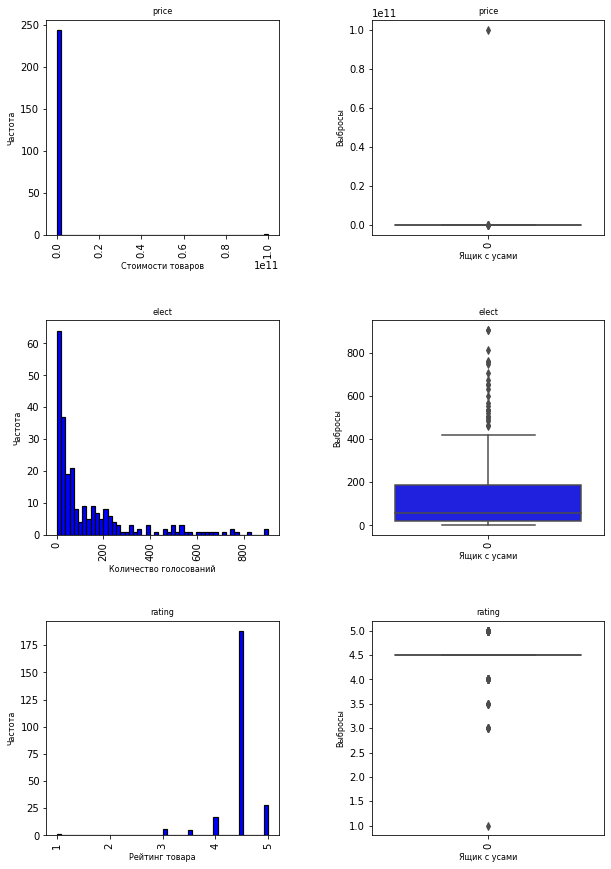

In [ ]:
eda_anomal_plot(df_inter,(10,15))

В случае кластеризации по методу DBSCAN, использующем принцип достижимости точек, аномалии будут увеличивать количество нераспознанных точек и их лучше сократить.

Для всех интервальных параметров исключим аномалии исходя из описательных статистик, отраженных на графиках, и следующих соображений. Из-за наличия одного большого выброса в цене не видно частотное распределение параметра `price` (обнаружено при повторной итерации проверки аноломалий). Предлагается сразу опустить верхнюю границу отсечения, установив ее примерно равной 100 тыс. рублей, поскольку более дорогие товары присутствуют в единичных экземплярах. Поскольку выборка небольшая, предлагается минимально ограничивать параметр `elect`.

In [ ]:
M, anomal = eda_anomal_fit(df_inter,
                            {'price':[0,1.e5],
                             'elect':[0,800]})
print('Количество аномальных наблюдений {:d}, что составляет {:.2%} от общего числа записей.'
        .format(anomal, anomal/df_inter.shape[0]))

Количество аномальных наблюдений 11, что составляет 4.49% от общего числа записей.


Потери данных в случае удаления аномалий приемлемые. Очищаем аномали.

In [ ]:
df_inter_noanomal = eda_anomal_clear(df_inter, M)

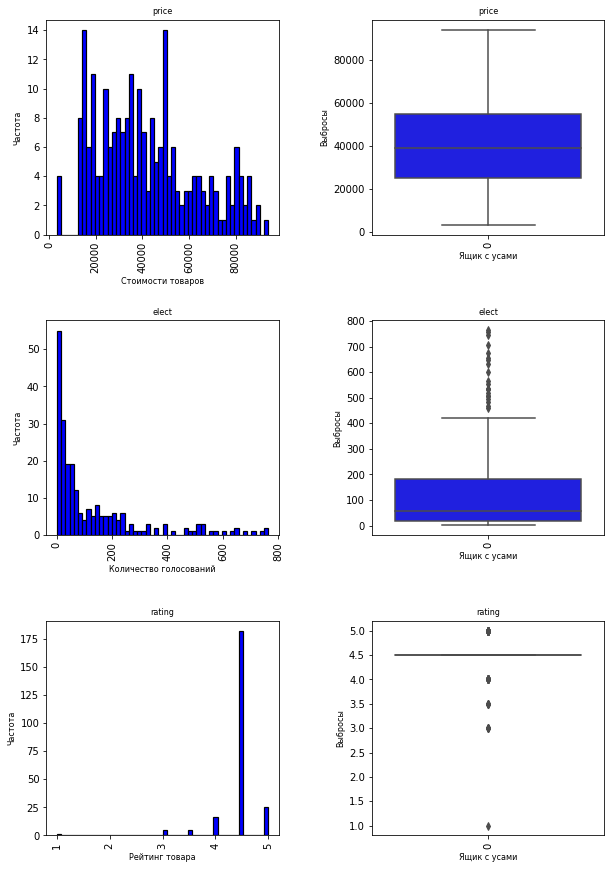

In [ ]:
df_inter_noanomal['price'].name = 'Cтоимости товаров'
df_inter_noanomal['elect'].name = 'Количество голосований'
df_inter_noanomal['rating'].name = 'Рейтинг товара'
eda_anomal_plot(df_inter_noanomal, (10,15))

**Вывод по ходу исследования**

Интервальные параметры не распределены по нормальному закону

#### Корреляции интервальных параметров

Проверим наличие линейной зависимости между параметрами. Построим корреляционную матрицу.

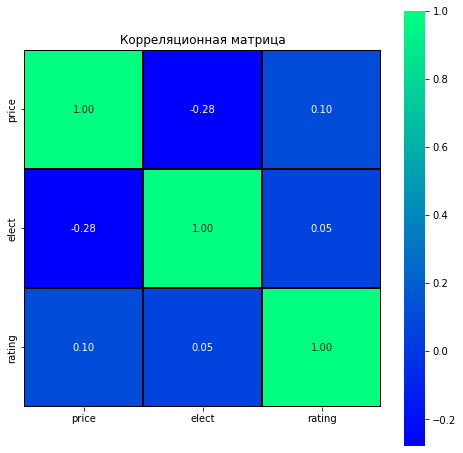

In [ ]:
eda_corr_matrix(df_inter_noanomal,8)

**Вывод по ходу исследования**

Цена и популярность товаров в выбранной категории находятся в слабой обратной линейной зависимости.

###Анализ категориальных параметров

Изучим категориальный параметр `vendor`.

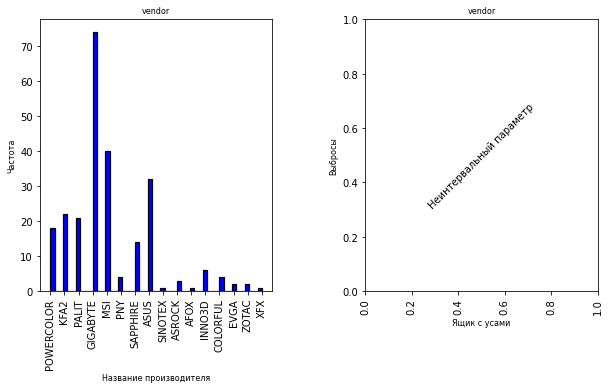

In [ ]:
df_categ = df_pred[['vendor']]
df_categ['vendor'].name = 'Название производителя'
eda_anomal_plot(df_categ, (10,5))

**Выводы по ходу исследования**
- Категориальные параметры не имеют аномалий
- Производители GIGABYTE и MSI имеют самую большую номенклатуру в выбранной категории товаров

#EDA. Выводы
- Популярность товаров в рассматриваемой категории растет с уменьшением их стоимости
- Производители GIGABYTE и MSI имеют самую большую номенклатуру в выбранной категории товаров
- Цена и популярность, а также цена и рейтинг товаров в выбранной категории находятся в слабой обратной линейной зависимости
- Интервальные параметры не распределены по нормальному закону

In [ ]:
df_inter_noanomal

,price,elect,rating
0,3399.0,98.0,4.0
1,3999.0,40.0,4.5
2,4099.0,49.0,4.0
3,4099.0,187.0,4.5
4,12999.0,4.0,3.5
...,...,...,...
252,84999.0,30.0,4.5
253,86999.0,1.0,5.0
255,89299.0,4.0,4.0
256,89999.0,57.0,4.5


#**Кластеризация**

Задача кластеризации позволяет проверить предположение о наличии некоторой ценовой политики онлайн-магазина в рассматриваемой категории товаров. Если кластеризация будет успешной с примерно равномерным распределением ассортимента по кластерам, это будет означать, что выявлены ценовые сегменты, подтверждаемые интересом клинтов, выраженным в количестве голосований. Если кластеризация не удастся, это будет означать, что магазин выбрал стратегию равномерного распределения ценового диапазона.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

Необходимые функции кластеризации:

In [ ]:
# --нормализация датасета стандартным скалером
def cl_normal(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)
# --алгоритм поиска ближайших соседей
def cl_neib(df):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df)
    # для каждой точки из набора находим ближайшую к ней и расстояние до нее
    distances, indices = nbrs.kneighbors(df)
    # сортируем массив расстояний
    distances = np.sort(distances, axis=0)
    # забираем только массив расстояний до соседей, отбрасывая расстояния
    # до обучающих точек
    return distances[:,1]
# --отрисовка для поиска e
def cl_plot_e(dist, hight=5, x_lim=(0,0), y_lim=(0,0)):
    plt.rcParams['figure.figsize']=hight,hight
    if x_lim[0] != 0: plt.xlim(x_lim[0], x_lim[1])
    if y_lim[0] != 0: plt.ylim(y_lim[0], y_lim[1])
    ln = sns.lineplot(data=dist, legend=None)
    ln.set_title('Зависимость расстояний от точек в множестве')
    ln.set_xlabel('Точки из набора')
    ln.set_ylabel('Расстояние между точками')
    plt.show()
#  --процедура поиска кластеров
def cl_dbscan_proc(df, samples,eps):
    dbscan = DBSCAN(eps=eps, min_samples=samples)
    cl = dbscan.fit(df).labels_
    noi = cl[(cl == -1)].shape[0]
    return (cl, cl.max() + 1, noi/cl.shape[0]) 
# --процедура расчета параметров кластера
def cl_param(df, cl_field):
    df = df.select_dtypes(include='number')
    ag = dict((d, 'mean') for d in df.columns)
    ag[cl_field] = 'count'
    df = df.groupby(cl_field).agg(ag)
    df.index.name = 'cluster'
    df = df.reset_index()
    df['clust_perc'] = (df[cl_field]/df[cl_field].sum()*100).round(1)
    return df

Для успешной работы алгоритма DBSCAN необходима нормализация датасета. Будем использовать нормальные скалер.

In [ ]:
X_st = cl_normal(df_inter_noanomal)

Попытаемся подобрать оптимальные параметры для DBSCAN.


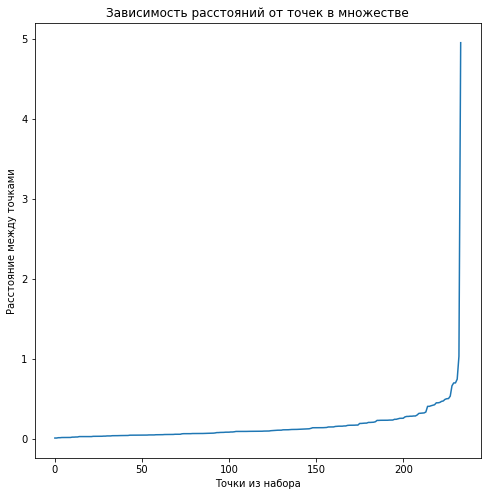

In [ ]:
dist = cl_neib(X_st)
cl_plot_e(dist,8,(0,176),(0,0.75))


Максимальная кривизна графика показывает с какого момента расстояние между точками начинает расти быстрее. Это значение расстояния и следует брать в качестве параметра для метода DBSCAN, поскольку если брать большее значение, тем самым мы будем искать более разреженные кластеры, а если меньшее - то слишком плотные.
Применим процедуру DBSCAN с параметрами, соответствующими максимальной кривизне данного графика.

In [ ]:
clusters, cl_count, noise = cl_dbscan_proc(X_st, 4, 0.4)
print('Количество найденных кластеров: {}\nПроцент шума: {:.2%}'.format(cl_count, noise))

Количество найденных кластеров: 6
Процент шума: 17.52%


Добавим разбиение на кластеры к нашему датасету и попробуем визуализировать.

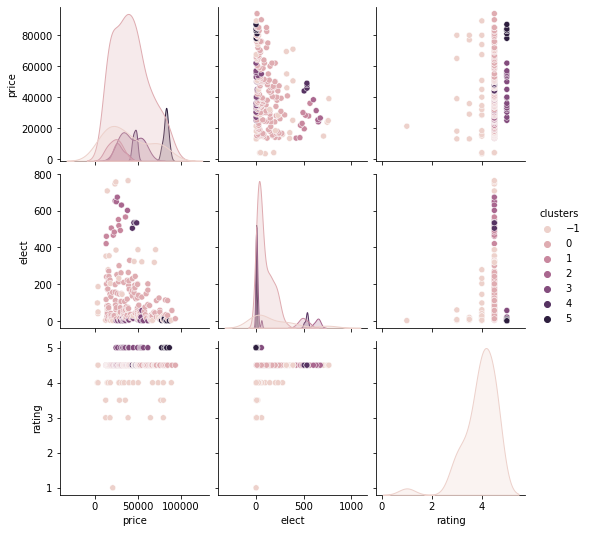

In [ ]:
df_cluster = df_inter_noanomal.copy()
df_cluster['clusters'] = clusters.tolist()
sns.pairplot(df_cluster, hue='clusters')

Посмотрим на структуру получившихся кластеров.

In [ ]:
cl_param(df_cluster, 'clusters')

,cluster,price,elect,rating,clusters,clust_perc
0,-1,37928.268293,180.170732,3.914634,41,17.5
1,0,42505.666667,91.246667,4.500000,150,64.1
2,1,23743.444444,496.555556,4.500000,9,3.8
3,2,29079.000000,642.000000,4.500000,5,2.1
4,3,42343.444444,9.333333,5.000000,18,7.7
5,4,46699.000000,527.250000,4.500000,4,1.7
6,5,82856.142857,4.285714,5.000000,7,3.0


**Выводы по ходу исследования**
- Процент шума незначительный - 18.2%
- Больше половины всех товаров относятся к одному кластеру №1, что может говорить об отсутствии выраженной политики сегментации ценовых предложений
- Есть группа товаров с небольшим количеством голосов и высоким рейтингом, средняя цена в которой почти совпадает с основной группой. Возможно, это т.н. "накрутки" рейтинга (кластер №4)
- Остальные кластеры оказались в пределах 2-3% от общего размера выборки, следовательно не могут нести содержательной информации

### Анализ производителя GIGABYTE

Для подтверждения предположения об отсутствии ценовых сегментов в данной категории товаров проанализируем товары одного поставщика (GIGABYTE), наиболее широко представленного в онлайн-магазине.

Количество аномальных наблюдений 1, что составляет 1.35% от общего числа записей.


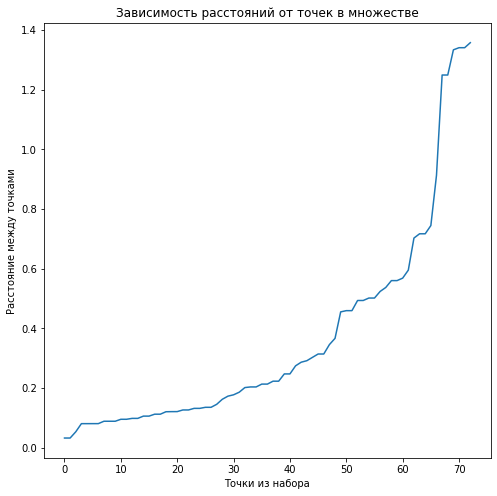

In [ ]:
df_GIGABYTE = df_pred[df_pred.vendor=='GIGABYTE'].select_dtypes(include='number')
M, anomal = eda_anomal_fit(df_GIGABYTE,
                            {'price':[0,1.e5],
                             'elect':[0,800]})
print('Количество аномальных наблюдений {:d}, что составляет {:.2%} от общего числа записей.'
        .format(anomal, anomal/df_GIGABYTE.shape[0]))
df_GIGABYTE = eda_anomal_clear(df_GIGABYTE, M)
X_st = cl_normal(df_GIGABYTE)
dist = cl_neib(X_st)
cl_plot_e(dist,8,(0,176),(0,0.75))

In [ ]:
clusters, cl_count, noise = cl_dbscan_proc(X_st, 3, 0.8)
print('Количество найденных кластеров: {}\nПроцент шума: {:.2%}'.format(cl_count, noise))

Количество найденных кластеров: 2
Процент шума: 20.55%


,cluster,price,elect,rating,clusters,clust_perc
0,-1,45425.666667,185.466667,4.1,15,20.5
1,0,40676.358491,113.584906,4.5,53,72.6
2,1,65519.000000,10.600000,4.0,5,6.8


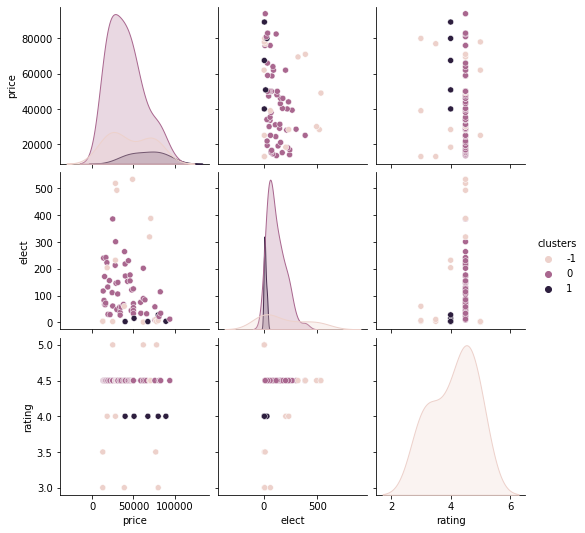

In [ ]:
df_GIGABYTE['clusters'] = clusters.tolist()
sns.pairplot(df_GIGABYTE, hue='clusters')
cl_param(df_GIGABYTE, 'clusters')

**Выводы по ходу исследования**

- Картина распределения по производителю GYGABIT практически аналогична общему датасету
- Шум соизмерим и составляет 19,5%
- Ядро товаров составляет 74.4%
- Отдельный класс сформировался вокруг дорогих товаров с небольшим количеством голосований

#Кластеризация. Выводы
- Онлайн-магазин не имеет выраженной сегментации ценового предложения в рассматриваемой товарной категории, ориентируясь на спрос в пределах 30-40 тыс. рублей
- Аналогичной стратегии придерживаются и крупные производители
- В статистике присутствует группа товаров из указанного выше ценового интервала с высоким рейтингом и небольшим количеством голосований, что может свидетельствовать об искуственных накрутках рейтинга

#**Проверка гипотез**

Оценим влияние производителя на популярность товаров в выбранной категории. Вначале изучим закон распределения параметра `elect` и если он будет близок к нормальному, то сможем оценить количественные показатели вышеуказанного влияния. Если же это окажется не так, выборочно проверим несколько гипотез о том, имеет ли параметр `vendor` статистически значимое влияние распределение параметра `elect`.

In [ ]:
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

Необходимые функции для проверки гипотез:

In [ ]:
# --получение списка вендоров
def vendors(df):
    return df.vendor.value_counts().index.tolist()
# --расчет гипотезы H_0 (1 - подтвеждается, 0 - отвергается)
def H_0(df, i, j, pvl):
    vnds = vendors(df)
    stat, pvalue = mannwhitneyu(df[df.vendor == vnds[i]].elect,
                                df[df.vendor == vnds[j]].elect)
    return pvalue >= pvl
# --расчет гипотезы H_1  (1 - подтвеждается, 0 - отвергается)
def H_1(df, i, j, pvl):
    vendors = df.vendor.value_counts().index.tolist()
    i_mode = df[df.vendor == vendors[i]].elect.mode()[0]
    j_mode = df[df.vendor == vendors[j]].elect.mode()[0]
    return i_mode <= j_mode
# --расчет бинарной матрицы 
def bmatrix(df, boolproc, pvl):
    dim = len(vendors(df))
    res = np.zeros((dim, dim), 'bool')
    for i in range(dim):
        for j in range(dim):
            res[i,j] = boolproc(df, i, j, pvl)
    return res
# --построение рейтинга вендоров
def rating_of_vendors(df):
    rtng = dict.fromkeys(df.columns.tolist() + df.index.tolist(),0)
    changed = True
    while changed:
        changed = False
        for cl in df.columns.tolist():
            for ln in df.index.tolist(): 
                if (df.loc[ln,cl] == True) & (rtng[cl] <= rtng[ln]):
                    rtng[cl] = rtng[ln] + 1
                    changed = True
    rtng = dict(sorted(rtng.items(),key=lambda item: item[1]))
    return rtng

Для начала подготовим датасет, который будет содержать только поля `elect` и `vendor`. Очистим его аномалий.

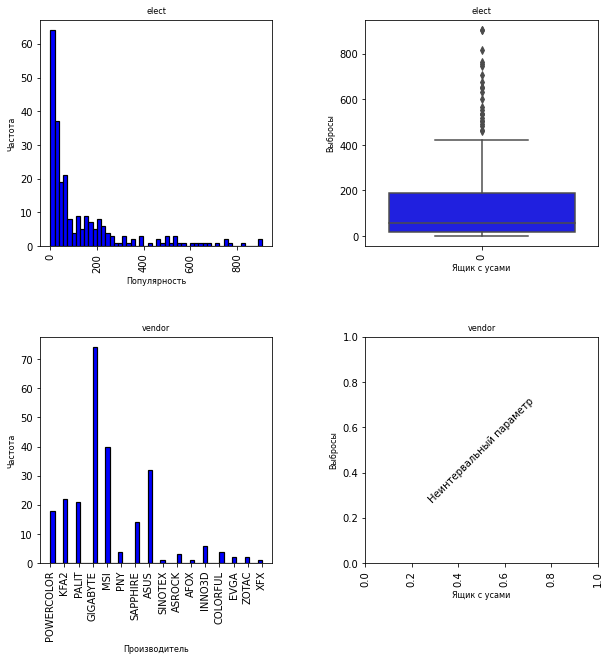

In [ ]:
df_hip = df_pred.loc[:,['elect','vendor']]
df_hip['elect'].name = 'Популярность'
df_hip['vendor'].name = 'Производитель'
eda_anomal_plot(df_hip,(10,10))


In [ ]:
M, anomal = eda_anomal_fit(df_hip,
                            {'elect':[0,400]})
print('Количество аномальных наблюдений {:d}, что составляет {:.2%} от общего числа записей.'
        .format(anomal, anomal/df_hip.shape[0]))

Количество аномальных наблюдений 25, что составляет 10.20% от общего числа записей.


In [ ]:
df_hip = eda_anomal_clear(df_hip, M)

##Гипотеза $H_0$: параметр `elect` подчиняется нормальному закону распределения.

Поскольку выборка небольшая, можем использовать критерий Шапиро-Уилкса. Уровень значимости примем равным **$\alpha$ = 1.0e-02**.


In [ ]:
shapiro_test = shapiro(df_hip.elect)
shapiro_test

ShapiroResult(statistic=0.8176013231277466, pvalue=2.4401471257685286e-15)

Поскольку $p_{value} < \alpha$, гипотеза $H_0$ отвергается - параметр `elect` не подчиняется нормальному закону распределения.

##Гипотезы для парных сравнений: $H_0$ (нет статистически значимых отличий в оценках популярности товаров разных производителей) и $H_1$ (мода выборки голосования за товары производителя А меньше или равна, чем у производителя Б)
Произведем попарное сравнение популярности производителей. Сравнение мод этих выборок будет корректным, если между выборками будет установлено статистически значимое различие (отвергнется гипотеза $H_0$). Поскольку распределение отлично от нормального, для проверки нипотезы $H_0$ будем использовать критерий Манна-Уитни-Уилкоксона о равенстве выборочных средних. Уровень значимости оставим таким же **$\alpha$ = 1.0e-02**.

Рассчитаем бинарную матрицу выполнения гипотез $H_0$.


In [ ]:
H_0_matr = bmatrix(df_hip, H_0, 0.01)

Рассчитаем бинарную матрицу попарных сравнений мод.

In [ ]:
H_1_matr = bmatrix(df_hip, H_1, 0.01)

Сопоставим результаты сравнения мод с резулуьтатами подтверждения гипотез $H_0$ в каждой паре.

In [ ]:
A = ~(H_1_matr | H_0_matr)
# создадим датафрейм из матрицы NumPy
vnds = vendors(df_hip)
B = pd.DataFrame(A, index = vnds, columns = vnds)
B.index.name = 'operand A'
B.columns.name = 'operand B'

Исключим все нулевые столбцы и строки.

In [ ]:
B = B[B.any(axis=1)]
B = B.T[B.T.any(axis=1)]
B

operand A,GIGABYTE,MSI,ASUS,KFA2,PALIT
operand B,,,,,
GIGABYTE,False,False,True,False,False
ASUS,False,True,False,True,True
SAPPHIRE,True,True,False,True,True
INNO3D,False,False,False,False,True
PNY,True,True,False,True,False
COLORFUL,True,True,False,True,True


В результате мы получили матрицу, отражающую связь значений мод (True, если мода Операнда А больше, чем Операнда В) с учетом статистической значимости различий соответствующих выборок.

Расчитаем и отобразим на графике получившийся рейтинг популярности вендоров.
Для этого осуществим попарную сортировку производителей по следующему правилу - если значение из вышеуказанной матрицы равно True, то производитель, указанный в наименовании столбца, получает рейтинг на 1 выше, чем производитель из наименования строки. Перебираем матрицу несколько раз - до тех пор, пока рейтинг не перестанет меняться. Это гарантирует, что все приведенные в матрице условия будут выполнены. 

In [ ]:
rt = rating_of_vendors(B)
rt

{'SAPPHIRE': 0,
 'INNO3D': 0,
 'PNY': 0,
 'COLORFUL': 0,
 'GIGABYTE': 1,
 'ASUS': 2,
 'MSI': 3,
 'KFA2': 3,
 'PALIT': 3}

#Проверка гипотез. Выводы
- Закон распределения количества голосов за товары на сайте онлайн-магазина отличен от нормального
- С помощью попарной проверки гипотез $H_0$ о равенстве средних для прочих распределений удалось выявить пары производителей, между которыми есть статистически значимое отношение популярности. Перебрав все пары, был построен рейтинг, на вершине которого находятся наиболее популярные производители.

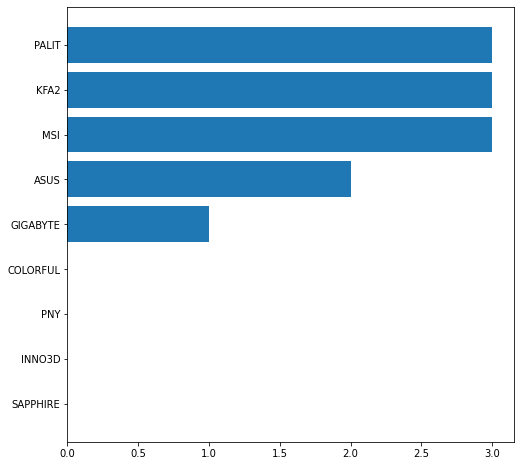

In [ ]:
values = list(rt.values())
keys = list(rt.keys())
plt.barh(y=keys, width=values)
plt.show()